In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from plot_losses import plot_losses
from dump_model import dump_model

Using TensorFlow backend.


# Prédiction de séquence
Hypothèse : on a détecté une récurrence, éventuellement par autocorrélation : 12 (normal, c'est annuel, 12 mois).

On apprend avec un lookhead de 15 (12 + 3), et on lance à prédiction en l'amorçant avec un échantillon de 15.

Et ça marche ! Mais il y a une embrouille dans le `input_shape` du LSTM. On a 1 _timestep_ de taille _look_back_ au lieu de _timestep_ _look_back_ de taille 1.

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

In [4]:
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

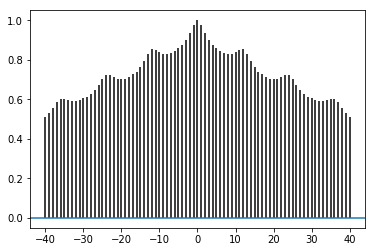

In [5]:
_,acorr,_,_ = plt.acorr( dataset[:,0], maxlags = 40 )

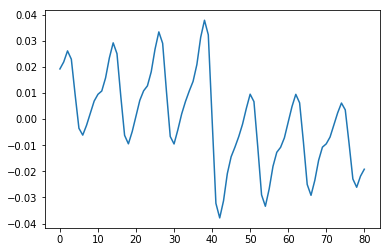

In [6]:
plt.plot(numpy.gradient(acorr))

In [7]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [8]:
# reshape into X=t and Y=t+1
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [9]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 10)          480       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 10)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


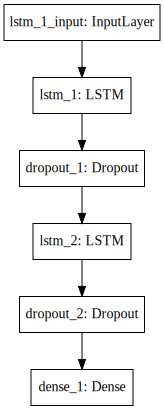

In [10]:
# reshape input to be [samples, time steps, features]

# build the model
model = Sequential()
# layer 1: LSTM
model.add(LSTM(10, input_shape=(None, 1), return_sequences=True))
model.add(Dropout(0.2))
# layer 2: LSTM
model.add(LSTM(10, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
# linear activation: a(x) = x
model.add(Dense(1, activation='linear'))
# compile the model
model.compile(loss="mse", optimizer="rmsprop")

dump_model(model)

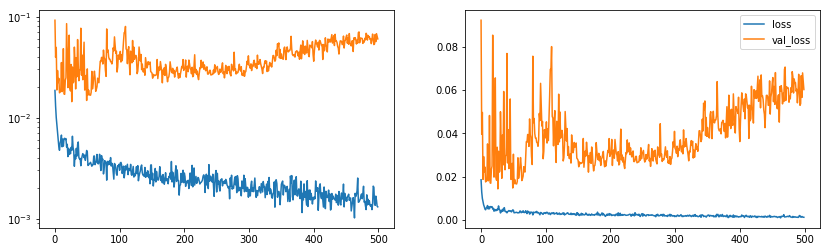

In [11]:
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.fit(trainX, trainY, epochs=500, batch_size=1, verbose=2, callbacks=[plot_losses], validation_data=(testX, testY))

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [13]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [14]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 15.95 RMSE
Test Score: 127.09 RMSE


In [15]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [16]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

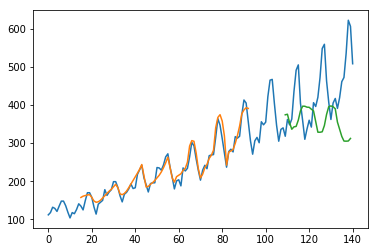

In [17]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

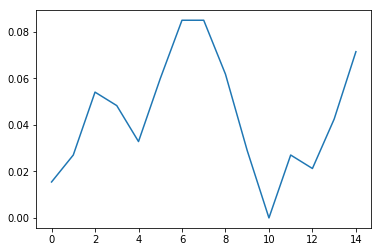

In [18]:
start = trainX[[0]] # Courbe d'amorçage
#start = numpy.random.random((1,1,15))/10 #trainX[[0]] # Courbe d'amorçage
plt.plot(start[0,:,0])
results = start.tolist()
#print(results[0][0])
#print(start)
results2 = [x for x in results[0][0]]
for _ in range(150):
    r = model.predict(numpy.array(results))
    #print(r)
    results2.append(r[0,0])
    results[0].append([r[0,0]])
    del results[0][0]
    #plt.plot(results[0][0])
    #print(results2)

results = numpy.array(results)

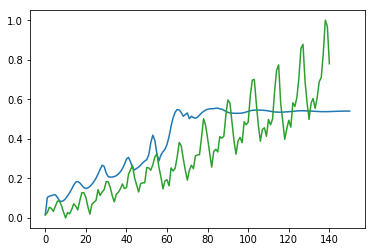

In [19]:
plt.plot(results2)
plt.plot(start[0,0])
plt.plot(dataset)


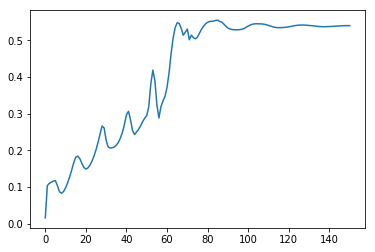

In [20]:
plt.plot(results2)
plt.plot(start[0,0])

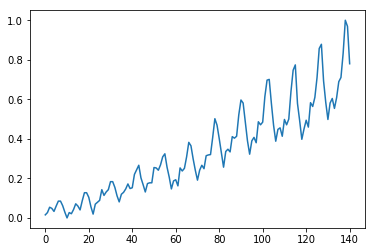

In [21]:
plt.plot(dataset[0:len(results2)])